In [5]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import binned_statistic

from astropy import units as u
from astropy.io import fits
from astropy.table import Table, join
from astropy.coordinates import match_coordinates_sky, SkyCoord

In [6]:
mpl.rc('font', size=14)

In [7]:
def profile_histogram(x, y, xbins, yerr=None, weights=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    weights : list or ndarray
        If not None (and weighted=True), will use this instead of yerr to weight 
        the summary statistics.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Weight the summary statistics, either by the uncertainty in y or the 
        provided weights.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if (yerr is None) and (weights is None):
            raise ValueError('need to define either yerr or weights if using weighted fit.')

        if weights is None:
            # weight based on yerr
            w = 1/yerr**2
        else:
            w = weights
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

In [24]:
cftab1 = Table.read('CF4/table1.fits')['PGC','rcmag','Wmx'].to_pandas().dropna()
cftab4 = Table.read('CF4/table4.fits')['PGC','Vls','Vcmb','DM-r','DMbest'].to_pandas().dropna()
cf4 = pd.merge(cftab1, cftab4, left_on=['PGC'], right_on=['PGC'])

cf4

,PGC,rcmag,Wmx,Vls,Vcmb,DM-r,DMbest
0,4,15.690000,154,4706,4109,33.310001,33.290001
1,16,14.120000,297,5809,5312,34.700001,34.700001
2,55,15.580000,179,5052,4454,34.000000,34.000000
3,68,14.790000,206,7740,7338,34.799999,34.810001
4,70,14.460000,433,7040,6447,35.099998,35.119999
...,...,...,...,...,...,...,...
6765,5952956,15.050000,368,10678,10806,36.060001,36.020000
6766,5953001,13.620000,288,2272,2249,33.240002,33.230000
6767,6719321,16.809999,73,3281,2732,31.990000,32.029999
6768,6724069,16.090000,113,7417,6880,34.139999,34.150002


In [9]:
for k in cf4.keys():
    print(k)

recno
DM
PGC
Name
Inc
e_Inc
HRV
Wmx
e_Wmx
logWmxi
e_logWmxi
m21
e_m21
umag
gmag
rmag
imag
zmag
W1mag
W2mag
__b_a_s
__b_a_W
Reu
Reg
Rer
Rei
Rez
ReW1
ReW2
ucmag
gcmag
rcmag
icmag
zcmag
W1cmag
W2cmag
Au
e_Au
Ag
e_Ag
Ar
e_Ar
Ai
e_Ai
Az
e_Az
AW1
e_AW1
AW2
e_AW2
u_mag
g_mag
r_mag
i_mag
z_mag
W1_mag
W2_mag
pW2_mag
Gu
Gg
Gr
Gi
Gz
Gw1
Gw2
pGu
pGg
pGr
pGi
pGz
pGW1
pGW2
pA-u
pA-g
pA-r
pA-i
pA-z
pA-W1
pA-W2
P1-W2
e_P1-W2
P1-pW2
P1-W1
QSflag
QWflag
Rsrc
ALFALFA
ADHI
Sloan
SimbadName
NED
LEDA
_RA
_DE
Vls
Vcmb
f
DMbest
e_DMbest
DM-r
e_DM-r
RMS-r
DM-i
e_DM-i
RMS-i
DM-z
e_DM-z
RMS-z
DM-W1
e_DM-W1
RMS-W1


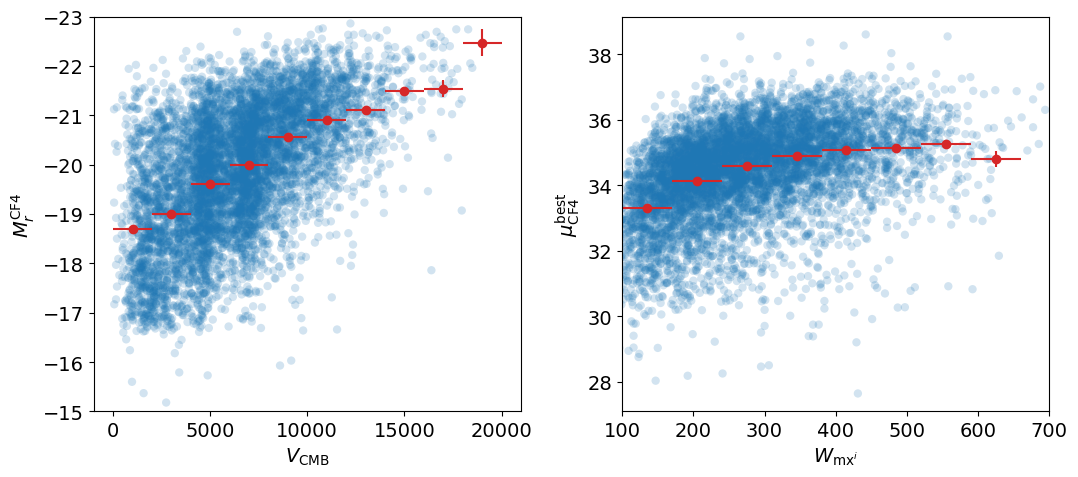

In [49]:
fig, axes = plt.subplots(1,2, figsize=(11,5), tight_layout=True)

ax = axes[0]
m_r = cf4['rcmag']
M_r = m_r - cf4['DM-r']

vbins = np.arange(0,22000,2000)
vc = 0.5*(vbins[1:] + vbins[:-1])
dv = 0.5*np.diff(vbins)

_, Mr_avg, Mr_std = profile_histogram(cf4['Vcmb'], M_r, vbins)
ax.errorbar(vc, Mr_avg, xerr=dv, yerr=Mr_std, fmt='o', color='tab:red')

ax.scatter(cf4['Vcmb'], M_r, ec='None', alpha=0.2)
ax.set(xlabel=r'$V_\mathrm{CMB}$',
       ylabel=r'$M_r^\mathrm{CF4}$',
       ylim=(-15,-23),
       )

ax = axes[1]

Wbins = np.arange(100,700,70)
Wc = 0.5*(Wbins[1:] + Wbins[:-1])
dW = 0.5*np.diff(Wbins)

_, mu_avg, mu_std = profile_histogram(cf4['Wmx'], cf4['DMbest'], Wbins)
ax.errorbar(Wc, mu_avg, xerr=dW, yerr=mu_std, fmt='o', color='tab:red')

ax.scatter(cf4['Wmx'], cf4['DMbest'], ec='None', alpha=0.2)
ax.set(xlabel=r'$W_{\mathrm{mx}^i}$',
       xlim=(100,700),
       ylabel=r'$\mu_\mathrm{CF4}^\mathrm{best}$',
       )

fig.savefig('cf4_mag_vs_vcmb.png', dpi=150)

In [36]:
# cftab1 = Table.read('CF4/table1.fits')['PGC', '_RA', '_DE'].to_pandas().dropna()
# cftab4 = Table.read('CF4/table4.fits')['PGC', 'DMbest', 'e_DMbest'].to_pandas().dropna()
# # cf4 = join(cftab1[['PGC', '_RA', '_DE']], cftab4, keys='PGC')
# cf4 = pd.merge(cftab1, cftab4, left_on=['PGC'], right_on=['PGC'])
# cf4 = Table.from_pandas(cf4)

desitf = Table.read('Y1/DESI-DR1_TF_pv_cat_v10.fits')#['SGA_ID', 'RA', 'DEC', 'Z_DESI', 'MU_TF', 'MU_TF_ERR']
desitf

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,MORPHTYPE_AI,JOHN_VI,Z_DESI_CMB,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,MU_ZCMB,R_ABSMAG_SB26,MU_ZCMB_ERR,R_ABSMAG_SB26_ERR,DWARF,GOOD_MORPH,R_ABSMAG_SB26_TF,R_ABSMAG_SB26_TF_ERR,R_ABSMAG_SB26_TF_ERR_STAT,R_ABSMAG_SB26_TF_ERR_SYS,MU_TF,MU_TF_ERR,LOGDIST,LOGDIST_ERR,V_PEC,VERR_PEC
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,bytes10,bytes6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
38.0,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,

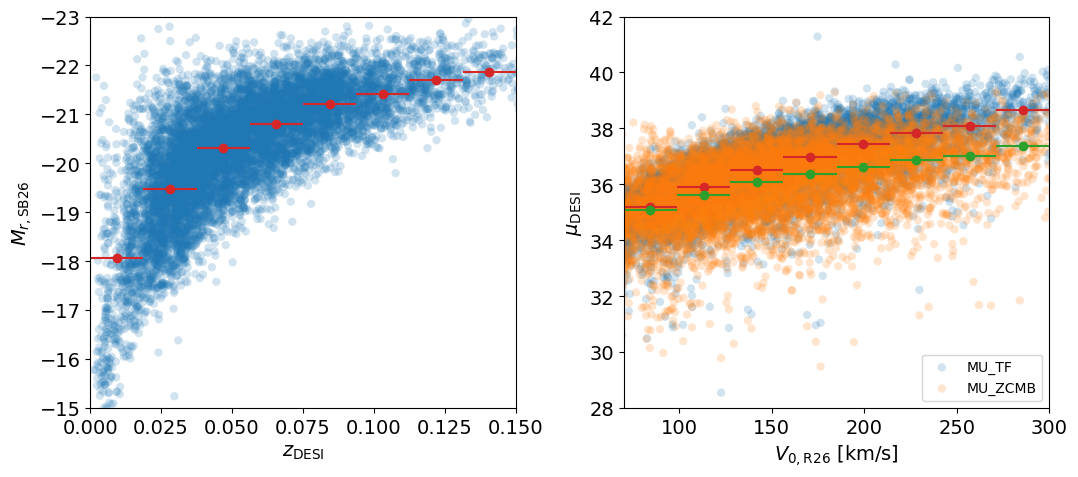

In [58]:
fig, axes = plt.subplots(1,2, figsize=(11,5), tight_layout=True)

ax = axes[0]

zbins = np.linspace(0,0.15,9)
zc = 0.5*(zbins[1:] + zbins[:-1])
dz = 0.5*np.diff(zbins)

_, Mr_avg, Mr_std = profile_histogram(desitf['Z_DESI'], desitf['R_ABSMAG_SB26'], zbins)
ax.errorbar(zc, Mr_avg, xerr=dz, yerr=Mr_std, fmt='o', color='tab:red')

ax.scatter(desitf['Z_DESI'], desitf['R_ABSMAG_SB26'], ec='None', alpha=0.2)
ax.set(xlabel=r'$z_\mathrm{DESI}$',
       xlim=(0,0.15),
       ylabel=r'$M_{r,\mathrm{SB26}}$',
        ylim=(-15,-23),
       )

ax = axes[1]

Vbins = np.linspace(70,300,9)
Vc = 0.5*(Vbins[1:] + Vbins[:-1])
dV = 0.5*np.diff(Vbins)

_, mu_avg, mu_std = profile_histogram(desitf['V_0p4R26'], desitf['MU_TF'], Vbins)
ax.errorbar(Vc, mu_avg, xerr=dV, yerr=mu_std, fmt='o', color='tab:red')
ax.scatter(desitf['V_0p4R26'], desitf['MU_TF'], ec='None', alpha=0.2, label='MU_TF')

_, mu_avg, mu_std = profile_histogram(desitf['V_0p4R26'], desitf['MU_ZCMB'], Vbins)
ax.errorbar(Vc, mu_avg, xerr=dV, yerr=mu_std, fmt='o', color='tab:green')
ax.scatter(desitf['V_0p4R26'], desitf['MU_ZCMB'], ec='None', alpha=0.2, label='MU_ZCMB')

leg = ax.legend(loc='lower right', fontsize=10)

ax.set(xlabel=r'$V_\mathrm{0,R26}$ [km/s]',
       xlim=(70,300),
       ylabel=r'$\mu_\mathrm{DESI}$',
       ylim=(28,42),
       )

fig.savefig('desi_mag_vs_zcmb.png', dpi=150)

In [112]:
desicoord = SkyCoord(ra=desitf['RA'], dec=desitf['DEC'], unit='degree')
cf4coord = SkyCoord(ra=cf4['_RA'], dec=cf4['_DE'], unit='degree')

idx, sep, dist = match_coordinates_sky(desicoord, cf4coord)
matched = sep < 1*u.arcsec
idx_desi = np.argwhere(matched).ravel()
idx_cf4 = idx[idx_desi]

In [113]:
cf4[idx_cf4]

PGC,_RA,_DE,DMbest,e_DMbest
int32,float64,float64,float32,float32
26636,141.020175,2.1215666666666664,36.75,0.31
50328,211.65839416666665,3.7487772222222215,36.28,0.19
1156203,347.3240375,0.06420555555555554,34.27,0.16
46262,199.26677916666665,8.399044444444444,35.18,0.27
21919,117.46347499999999,18.828988888888887,34.14,0.28
30684,156.67402499999997,3.862108333333333,32.73,0.18
67242,325.9065247222222,2.6351036111111106,34.95,0.21
61017,268.027925,28.90529444444444,34.7,0.16
90789,114.45321666666665,32.213138888888885,35.38,0.12


In [114]:
desitf[idx_desi]

SGA_ID,RA,DEC,Z_DESI,MU_TF,MU_TF_ERR
float64,float64,float64,float64,float64,float64
15509.0,141.0201855398152,2.12157957136872,0.0368733238387036,35.928671740543514,0.1564550312234948
18021.0,211.6583859776107,3.7487394666299263,0.0405925794581742,35.8710576162122,0.22438327750989898
24070.0,347.32408867883385,0.06425040245581817,0.0157449820591052,34.23056021643425,0.41170123896235805
30482.0,199.2668793446124,8.398909803826829,0.023956858165340596,34.51115752660974,0.39238610448410294
33557.0,117.46353994502626,18.829106444816418,0.0154494030929053,34.15234046819968,0.29684895052850796
36792.0,156.67417589631518,3.8619679909103795,0.00716009678398891,32.817853176101245,0.21065377133597799
52414.0,325.906615814736,2.635070177398477,0.0262813946923327,34.77909439080803,0.2249228753178361
60045.0,268.0280514902425,28.905178890871635,0.0216523284927146,34.195931185011034,0.2989276749474789
60180.0,114.45317234467242,32.21320983316677,0.0270833081335129,34.55459439822676,0.367049507435459


In [115]:
z_desi = desitf[idx_desi]['Z_DESI']
mu_desi = desitf[idx_desi]['MU_TF']
mu_desi_err = desitf[idx_desi]['MU_TF_ERR']
mu_cf4 = cf4[idx_cf4]['DMbest']
mu_cf4_err = cf4[idx_cf4]['e_DMbest']

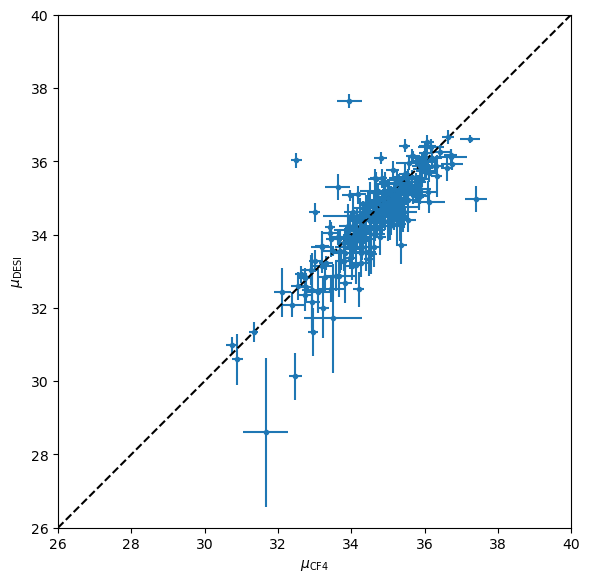

In [124]:
fig, ax = plt.subplots(1,1, figsize=(6,6), tight_layout=True)
ax.errorbar(mu_cf4, mu_desi, xerr=mu_cf4_err, yerr=mu_desi_err, fmt='.')
ax.plot((26,40), (26,40), ls='--', color='k')
ax.set(xlabel=r'$\mu_\mathrm{CF4}$',
       xlim=(26,40),
       ylabel=r'$\mu_\mathrm{DESI}$',
       ylim=(26,40),
       aspect='equal')
fig.savefig('desitf_cf4_crossmatch.png', dpi=150);

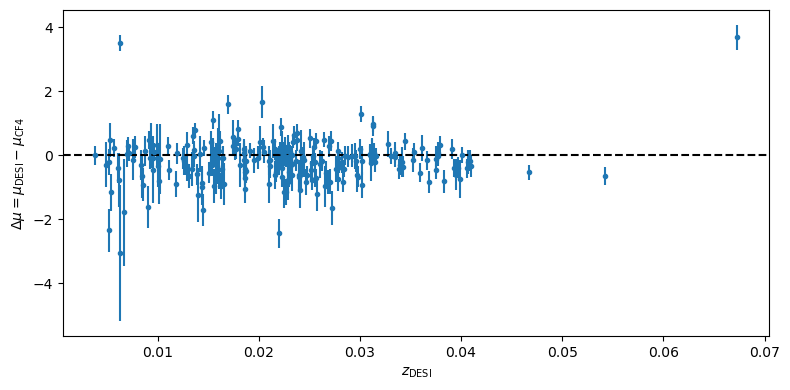

In [126]:
fig, ax = plt.subplots(1,1, figsize=(8,4), tight_layout=True)
dmu = mu_desi - mu_cf4
dmu_err = np.sqrt(mu_desi_err**2 + mu_cf4_err**2)

ax.errorbar(z_desi, dmu, yerr=dmu_err, fmt='.')
ax.axhline(0, ls='--', color='k')

ax.set(xlabel='$z_\mathrm{DESI}$',
       ylabel=r'$\Delta\mu = \mu_\mathrm{DESI} - \mu_\mathrm{CF4}$')
fig.savefig('desitf_cf4_diff.png', dpi=150);